# [Hands-On] Understanding Conditional-GAN and Implementation

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is part of the generative model series, specifically focusing on the implementation of Conditional Generative Adversarial Networks (CGANs) for generating class-specific data samples.

## What is a Conditional Generative Adversarial Network (CGAN)?
A CGAN is an extension of the original Generative Adversarial Network (GAN) architecture. In a CGAN, both the generator and discriminator receive **additional conditional information**, such as class labels, enabling the generation of data that is conditioned on specific attributes. This added conditional input enhances the model's ability to produce more diverse and class-specific outputs.

### In this Notebook:
We will demonstrate the use of CGANs for generating digit images conditioned on class labels from the MNIST dataset. This notebook provides a comprehensive guide on the fundamental concepts of CGANs and their implementation using PyTorch.

### Objectives:
Understand the basic structure and functioning of CGANs.
Implement the Generator and Discriminator networks with conditional inputs.
Train the CGAN on the MNIST dataset to generate digit images conditioned on class labels.
Visualize the generated images and evaluate the performance of the CGAN.


### Key Sections:
#### Environment Setup
Ensure the necessary libraries are imported, including PyTorch for model building, torchvision for dataset utilities, and matplotlib for visualization.

#### CGAN Generator and Discriminator
- Generator Network: Responsible for generating data that mimics real data, conditioned on class labels. It takes a random noise vector and a conditional label as inputs. The label is embedded into a continuous vector and concatenated with the noise vector. The combined input is then passed through the network to generate data conditioned on the label.
- Discriminator Network: Evaluates the generated data against real data, considering the conditional labels. It determines the probability that a given image, paired with its label, is real (from the dataset) or fake (from the Generator).

#### Training the CGAN
The training process involves alternating between training the Discriminator and the Generator. The Discriminator learns to distinguish between real and fake images conditioned on labels, while the Generator improves its ability to create realistic images that match the given labels.

#### Evaluating and Visualizing Results
After training, we will evaluate the performance of the CGAN by visualizing the images generated by the Generator. This section will highlight the strengths and limitations of the CGAN implementation.

By the end of this lecture, you will have a practical understanding of CGANs, including their architecture, implementation, and training process. You will also gain insights into the challenges and considerations involved in generating realistic and class-specific data with CGANs.

Let's dive into the fascinating world of Conditional Generative Adversarial Networks! ​

## Environment Setup

In [1]:
!pip install imageio

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np


In [3]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preparation for CGAN

We use the MNIST dataset for training our CGAN. Each image is paired with a class label, used as a condition for both the generator and discriminator.


In [4]:
# DataLoader for MNIST
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(28),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
                   ])),
    batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.2MB/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 366kB/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.92MB/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.95MB/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



## Conditional Generative Adversarial Networks (CGAN)

Conditional Generative Adversarial Networks (CGANs) augment the traditional GAN architecture by conditioning the model on additional information, such as class labels. This approach allows CGANs to generate data that is more specific and relevant to the given condition, enhancing the versatility and applicability of GANs in various tasks.


### CGAN Generator

The CGAN Generator receives a noise vector and a conditional label as inputs. The label is embedded into a continuous vector and concatenated with the noise vector. This combined input is then passed through the network to generate data conditioned on the label.


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(10, 10)  # Embedding for 10 classes
        self.model = nn.Sequential(
            nn.Linear(100 + 10, 256),  # Noise dim = 100, Label dim = 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),  # Output image size = 28x28
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.embedding(labels)
        input_vector = torch.cat([noise, label_embedding], dim=1)
        return self.model(input_vector).view(-1, 1, 28, 28)


### CGAN Discriminator

The Discriminator in CGAN also receives a conditional label along with the input data. The label is embedded and concatenated with the input data, providing the Discriminator with the context to make more informed decisions about the authenticity of the input.


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(10, 10)  # Embedding for 10 classes
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 1024),  # Image size = 28x28, Label dim = 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embedding = self.embedding(labels)
        img_flat = img.view(img.size(0), -1)
        input_vector = torch.cat([img_flat, label_embedding], dim=1)
        return self.model(input_vector)


## Training Loop for CGAN

The training loop involves alternating between updating the discriminator and the generator. The discriminator is trained to distinguish real images from generated ones, while the generator is trained to produce images that are classified as real by the discriminator.


In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()


In [8]:
import os
import torch
from torchvision.utils import save_image

# Number of epochs
num_epochs = 100

# For visualizing the progress
fixed_noise = torch.randn(64, 100, device=device)
fixed_labels = torch.randint(0, 10, (64,), device=device)

os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator with real images
        discriminator.zero_grad()
        outputs = discriminator(real_images.to(device), labels.to(device))
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train Discriminator with fake images
        noise = torch.randn(batch_size, 100, device=device)
        gen_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_images = generator(noise, gen_labels)
        outputs = discriminator(fake_images.detach(), gen_labels)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize for discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images, gen_labels)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize for generator
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    if epoch == 0:
        save_image(real_images, './images/real_images.png')

    fake_images = generator(fixed_noise, fixed_labels)
    save_image(fake_images, f'./images/fake_images_epoch_{epoch+1:04d}.png')

    discriminator_results = discriminator(fake_images, fixed_labels).cpu().detach().numpy().reshape(8, 8)
    np.save(f'./results/discriminator_outputs_epoch_{epoch+1:04d}.npy', discriminator_results)

print('Training finished.')

Epoch [1/100], Step [200/938], d_loss: 0.6827, g_loss: 1.9304, D(x): 0.87, D(G(z)): 0.41
Epoch [1/100], Step [400/938], d_loss: 0.4242, g_loss: 2.6190, D(x): 0.77, D(G(z)): 0.10
Epoch [1/100], Step [600/938], d_loss: 0.5539, g_loss: 2.3374, D(x): 0.81, D(G(z)): 0.22
Epoch [1/100], Step [800/938], d_loss: 0.3981, g_loss: 4.4234, D(x): 0.90, D(G(z)): 0.21
Epoch [2/100], Step [200/938], d_loss: 0.3748, g_loss: 3.9002, D(x): 0.95, D(G(z)): 0.23
Epoch [2/100], Step [400/938], d_loss: 0.3855, g_loss: 3.2755, D(x): 0.91, D(G(z)): 0.19
Epoch [2/100], Step [600/938], d_loss: 0.5451, g_loss: 3.1542, D(x): 0.92, D(G(z)): 0.33
Epoch [2/100], Step [800/938], d_loss: 0.5040, g_loss: 1.5720, D(x): 0.78, D(G(z)): 0.06
Epoch [3/100], Step [200/938], d_loss: 0.6342, g_loss: 3.1934, D(x): 0.89, D(G(z)): 0.35
Epoch [3/100], Step [400/938], d_loss: 0.6349, g_loss: 2.1120, D(x): 0.89, D(G(z)): 0.36
Epoch [3/100], Step [600/938], d_loss: 0.4746, g_loss: 1.9590, D(x): 0.81, D(G(z)): 0.18
Epoch [3/100], Step [

## Results Visualization
After training, we visualize the generated images to evaluate the performance of our GAN.


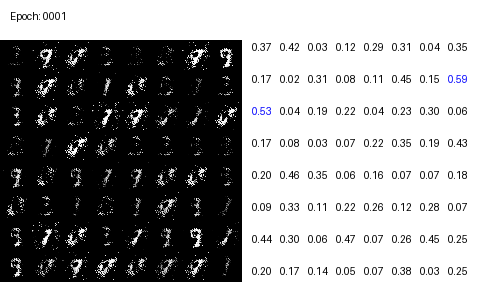

In [9]:
import os
import torch
import imageio
from PIL import Image, ImageDraw, ImageFont
import glob
import numpy as np

def create_gif_with_predictions(image_folder='./images', result_folder='./results', gif_name='CGAN_training_progress.gif', duration=200):
    images = []

    fns = glob.glob(os.path.join(image_folder, 'fake_images_epoch_*.png'))
    filenames = sorted(fns, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Load default font
    font = ImageFont.load_default()

    for filename in filenames:
        epoch_number = filename.split('_')[-1].split('.')[0]
        image = Image.open(filename)
        result_filename = f'discriminator_outputs_epoch_{epoch_number}.npy'
        discriminator_outputs = np.load(os.path.join(result_folder, result_filename))

        new_image = Image.new('RGB', (image.width * 2, image.height + 40), 'white')
        new_image.paste(image, (0, 40))

        draw = ImageDraw.Draw(new_image)
        text_x = 10
        text_y = 10
        draw.text((text_x, text_y), f'Epoch: {epoch_number}', fill="black", font=font)

        for idx in range(8):
            for jdx in range(8):
                position = (image.width + 10 + jdx * 28, 40 + idx * 28 + 1 + idx * 4)
                text = f'{discriminator_outputs[idx, jdx]:.2f}'
                if discriminator_outputs[idx, jdx] > 0.5:
                    draw.text(position, text, fill="blue", font=font, stroke_fill="blue")
                else:
                    draw.text(position, text, fill="black", font=font)

        images.append(new_image)

    imageio.mimsave(gif_name, images, duration=duration / 1000.0)
    return gif_name

gif_fn = create_gif_with_predictions()

# Display the created GIF in Jupyter Notebook
from IPython.display import Image as IPImage, display
display(IPImage(filename=gif_fn))


## Conclusion
In this lecture, we explored the implementation of Conditional Generative Adversarial Networks (CGANs) to generate digit images from the MNIST dataset conditioned on class labels. We began by understanding the core components of CGANs: the Generator and the Discriminator, both enhanced with conditional inputs to guide the data generation process.

We implemented both networks using PyTorch. The Generator network was designed to take a random noise vector and a conditional label as inputs, producing 28x28 images through a series of fully connected layers. The Discriminator network was structured to evaluate the authenticity of the images, conditioned on the corresponding labels, distinguishing real images from those generated by the Generator.

The training process involved a delicate balance between the two networks. We alternated training the Discriminator to improve its ability to detect fake images and the Generator to produce more realistic images that matched the given labels. This iterative process helped both networks to continually enhance their performance.

Throughout the training, we visualized the images generated by the Generator to monitor progress and assess the quality of the generated samples. Initially, the generated images lacked realism, but as training progressed, the Generator began producing increasingly convincing digit images that accurately reflected the conditional labels.